In [1]:
import os
import sys

import math
from copy import deepcopy

import matplotlib.pyplot as plt
import sympy as sm
import networkx as nx

import numpy
from numpy import dot

import pprint
from pprint import pprint

import json

sys.path.append(os.path.abspath('../'))

from gpa.utils import disp_error_plot, disp_graph_with_custom_labels
from gpa.GPA import GPA


In [14]:
path = 'models/gpa-1.json'

with open(path, 'r') as fp:
    gpa1 = json.load(fp)

In [15]:
GPA_1 = GPA(gpa1)

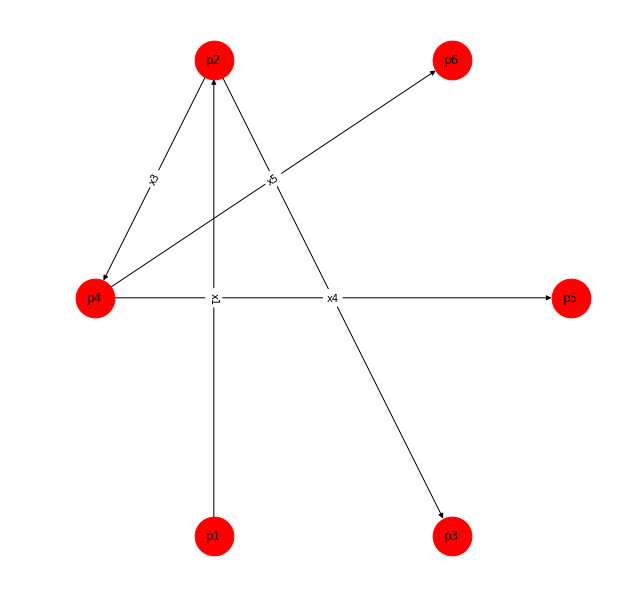

In [16]:
disp_graph_with_custom_labels(gr=GPA_1.gpa, 
                              edge_label='var', 
                              node_label='var')

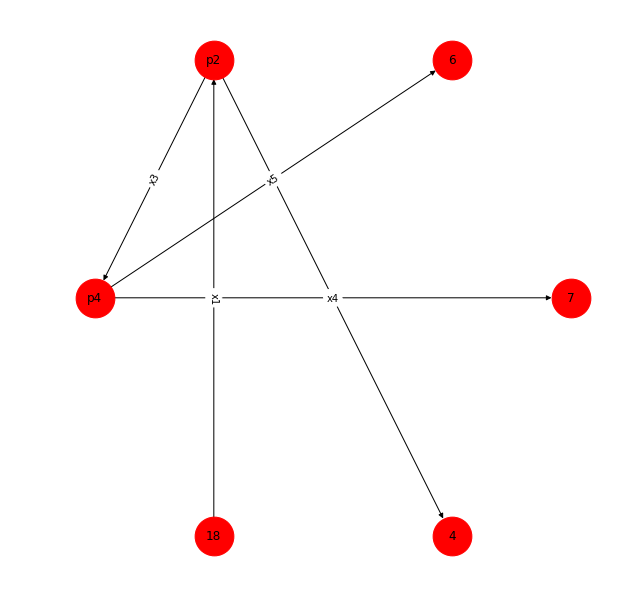

In [17]:
disp_graph_with_custom_labels(gr=GPA_1.gpa, 
                              edge_label='x', 
                              node_label='P')

In [18]:
GPA_1.variables

[p2, p4, x1, x2, x3, x4, x5]

In [19]:
appoximation = GPA_1.solve_equations(start_approximation=gpa1['approximation'])
GPA_1.construct_sense_matrix()

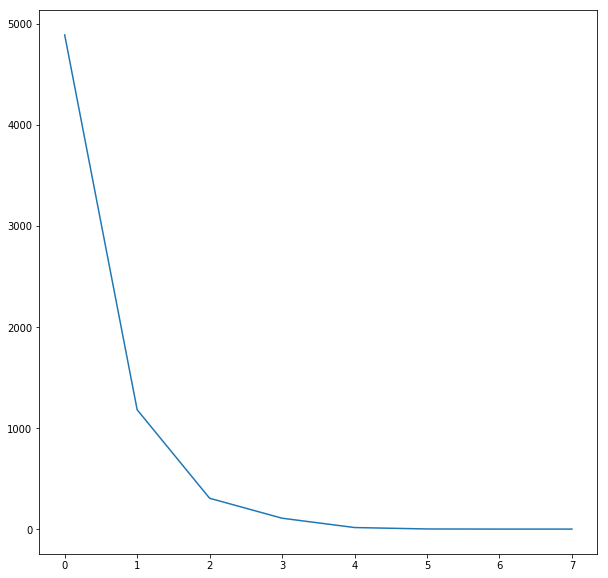

In [20]:
disp_error_plot(errors=GPA_1.solving_errors)

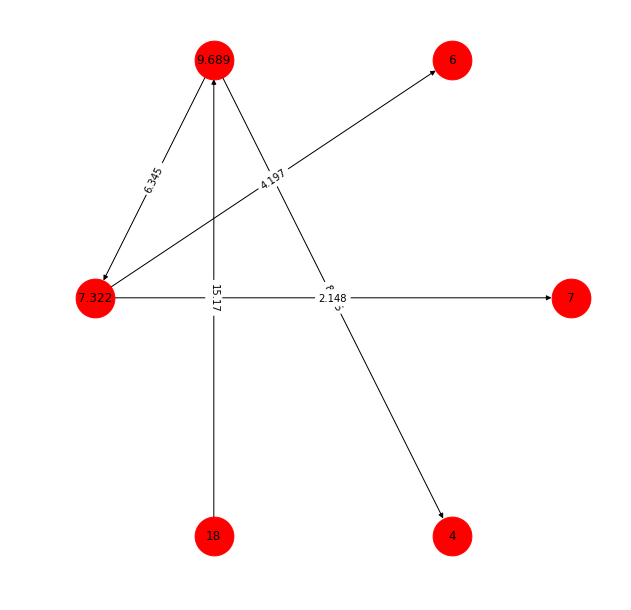

In [21]:
disp_graph_with_custom_labels(gr=GPA_1.gpa, 
                              edge_label='x', 
                              node_label='P')

In [22]:
GPA_1.variables

[p2, p4, x1, x2, x3, x4, x5]

In [23]:
GPA_1.dp_var

Matrix([
[ 0.653251212606509*p1 - 1.12294031214548*p3 + 1.68373964655373*p5 + 0.861597175409854*p6],
[0.23835509075696*p1 - 0.409732940177964*p3 - 0.463793620254566*p5 - 0.237330797550768*p6]])

In [24]:
GPA_1.dq_var

Matrix([
[   -1.41382885723871*p1 + 1.33244380210664*p3 - 1.99786972837884*p5 - 1.02234268720305*p6],
[0.296098622690364*p1 + 0.588936999423087*p3 + 0.763187240517267*p5 + 0.390535420416338*p6],
[  0.776949338813993*p1 - 1.33557767090522*p3 + 1.89777722120371*p5 - 0.773610522232499*p6],
[ 0.340780895734351*p1 - 0.585803130624508*p3 - 0.663094733342142*p5 + 1.40541778901921*p6]])